In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('CC GENERAL.csv')
data = data.set_index('CUST_ID')
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS                    8637 non-null float64
PRC_FULL_PAYMENT         

# Data analysis and preprocessing

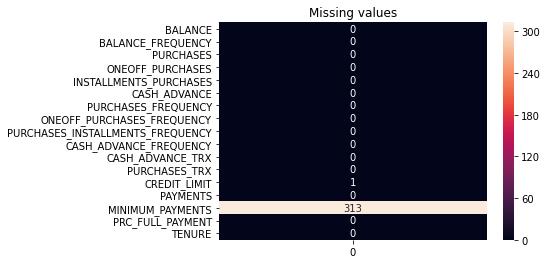

In [5]:
#Check if there is any missing value
plt.title('Missing values')
sns.heatmap(data.isna().sum().to_frame(),fmt='d',annot=True)
plt.show()

There is one missing value for credit limit feature. We can deal with it by simply dropping it

In [6]:
#Drop the null values
#You can use one of these methods.
#x=data[~data.CREDIT_LIMIT.isna()]
data.dropna(subset=['CREDIT_LIMIT'],inplace=True)

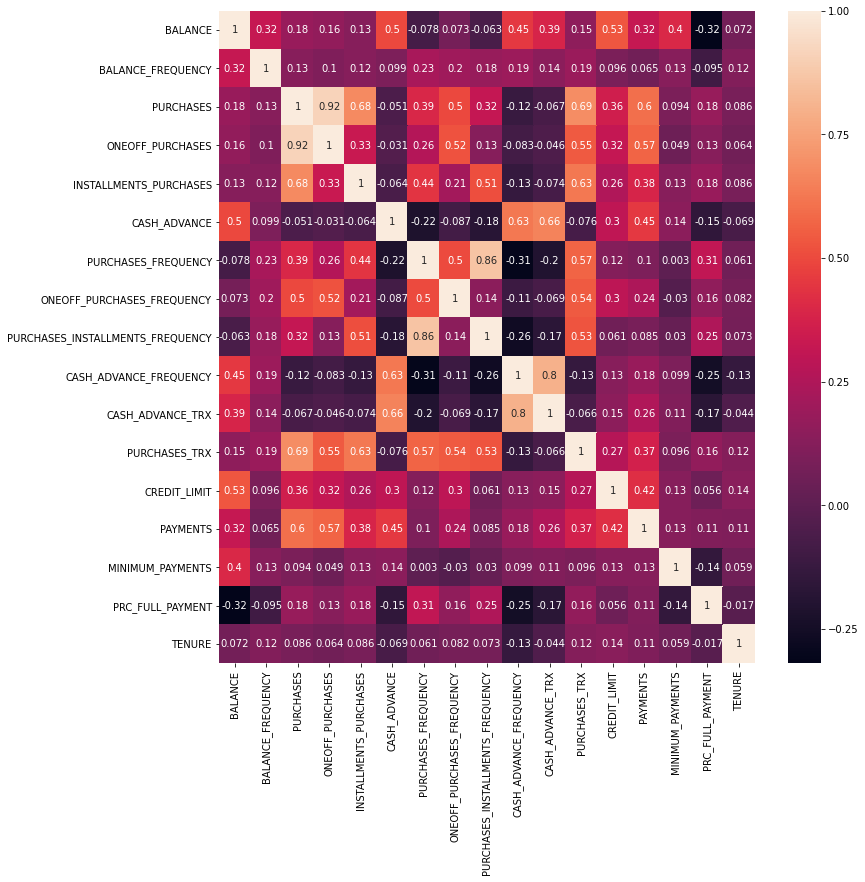

In [7]:
#plt.title('Pearson correlation')
plt.figure(figsize=(12,12))
sns.heatmap(data.corr('pearson'),annot=True)
plt.show()

No feature seems to be correlated to MINIMUM_PAYMENTS to help us impute the missing value. 
Thus we will be using the median value to do so

In [8]:
data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].median(),inplace=True)

Let's visualize the distribution of our data

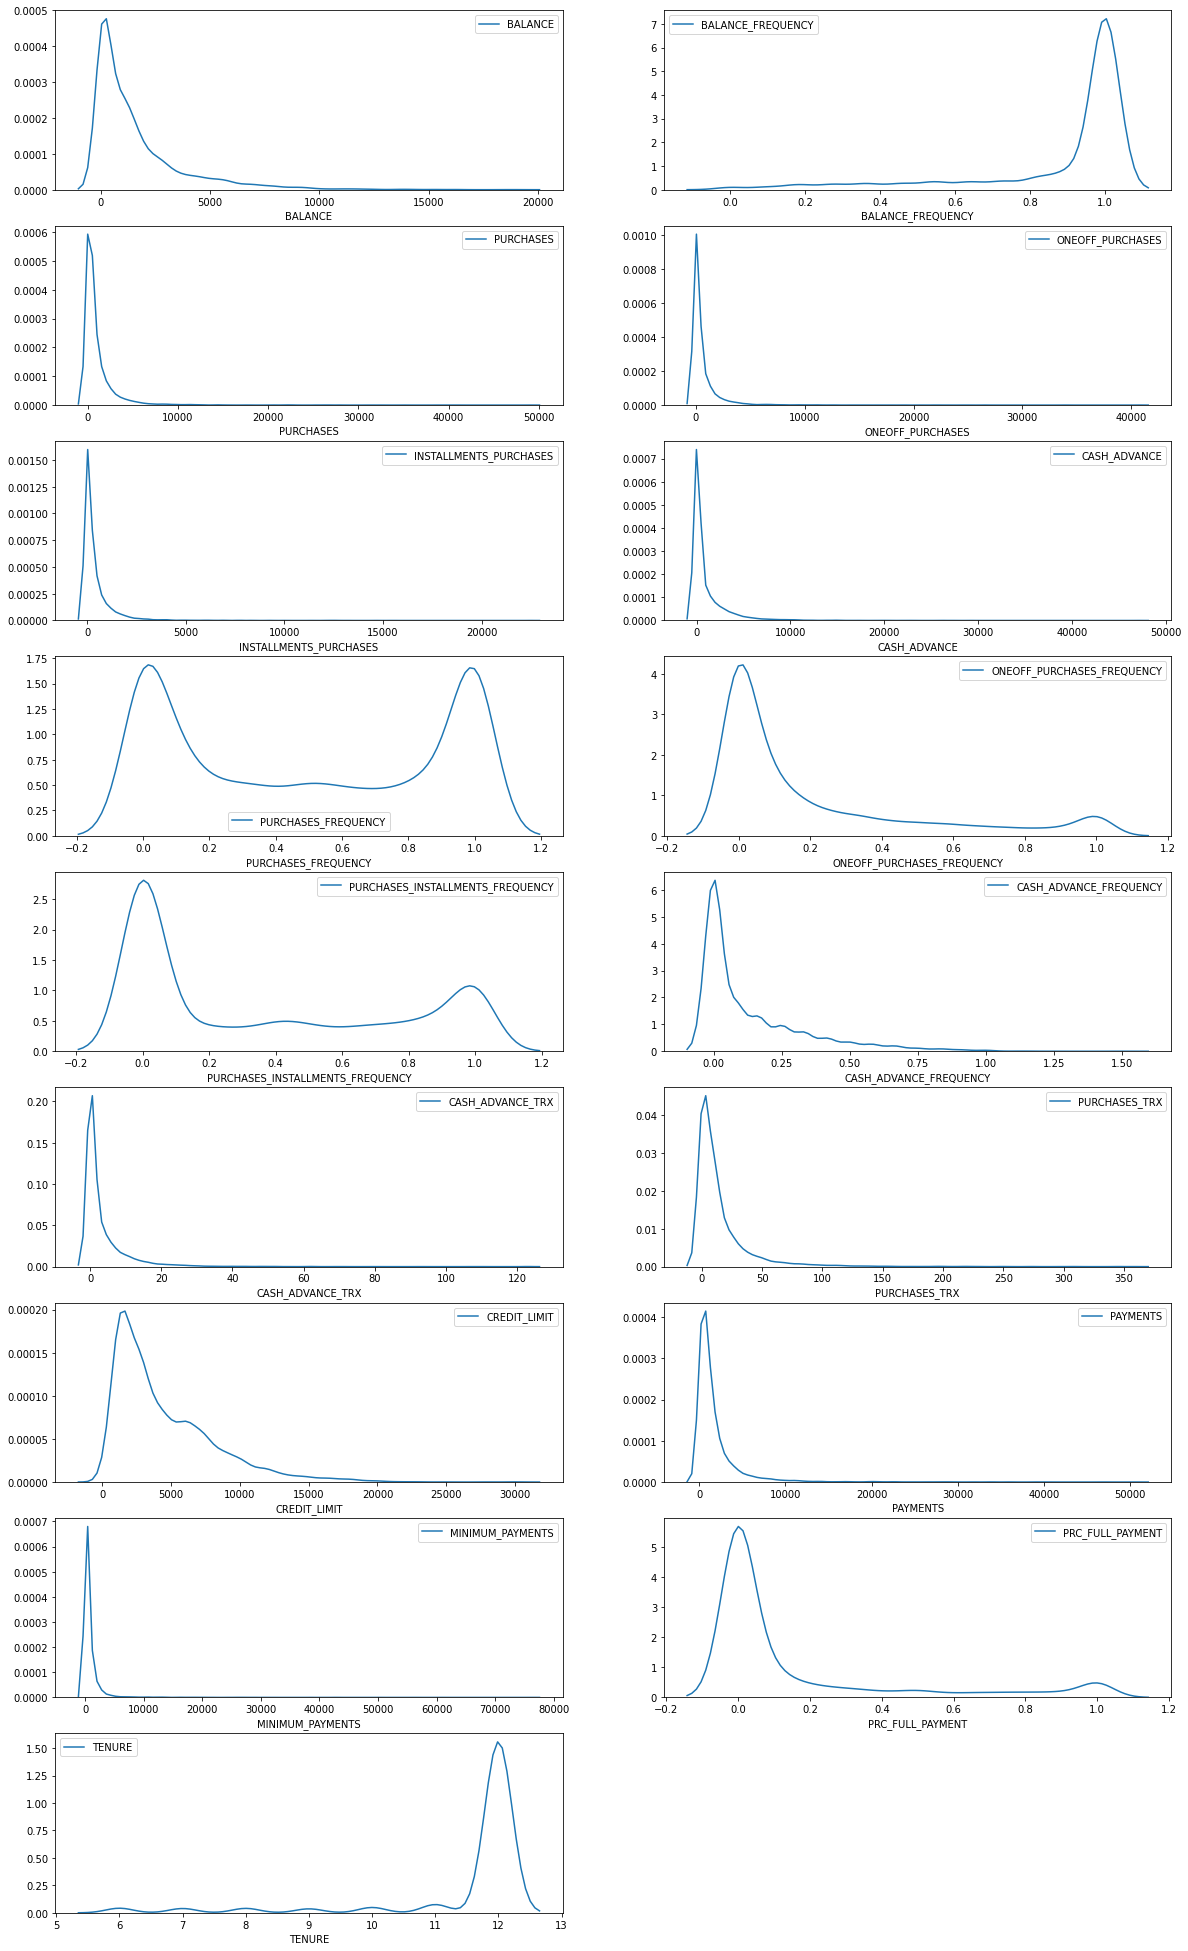

In [9]:
plt.figure(figsize=(20,35))
for i, col in enumerate(data.columns):
    if data[col].dtype!='object':
        ax = plt.subplot(9,2,i+1)
        sns.kdeplot(data[col],ax=ax)
        plt.xlabel(col)
plt.show()

As we can observe, the data is highly skewed in different directions. 
This can be expected in real world as there are always customers who have very high amount of transactions compared to the majority
Whether to handle it or not will depend on the application we want to use of the model. 
For example, for anomaly detection, we would leave it as it is because we would want a model that can detect them.
But in our case, we will handle them by using a logarithmic function

In [10]:
cols = ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT']

In [11]:
for col in cols:
    data[col] = np.log(1+data[col])

Let's check if there is any improvement

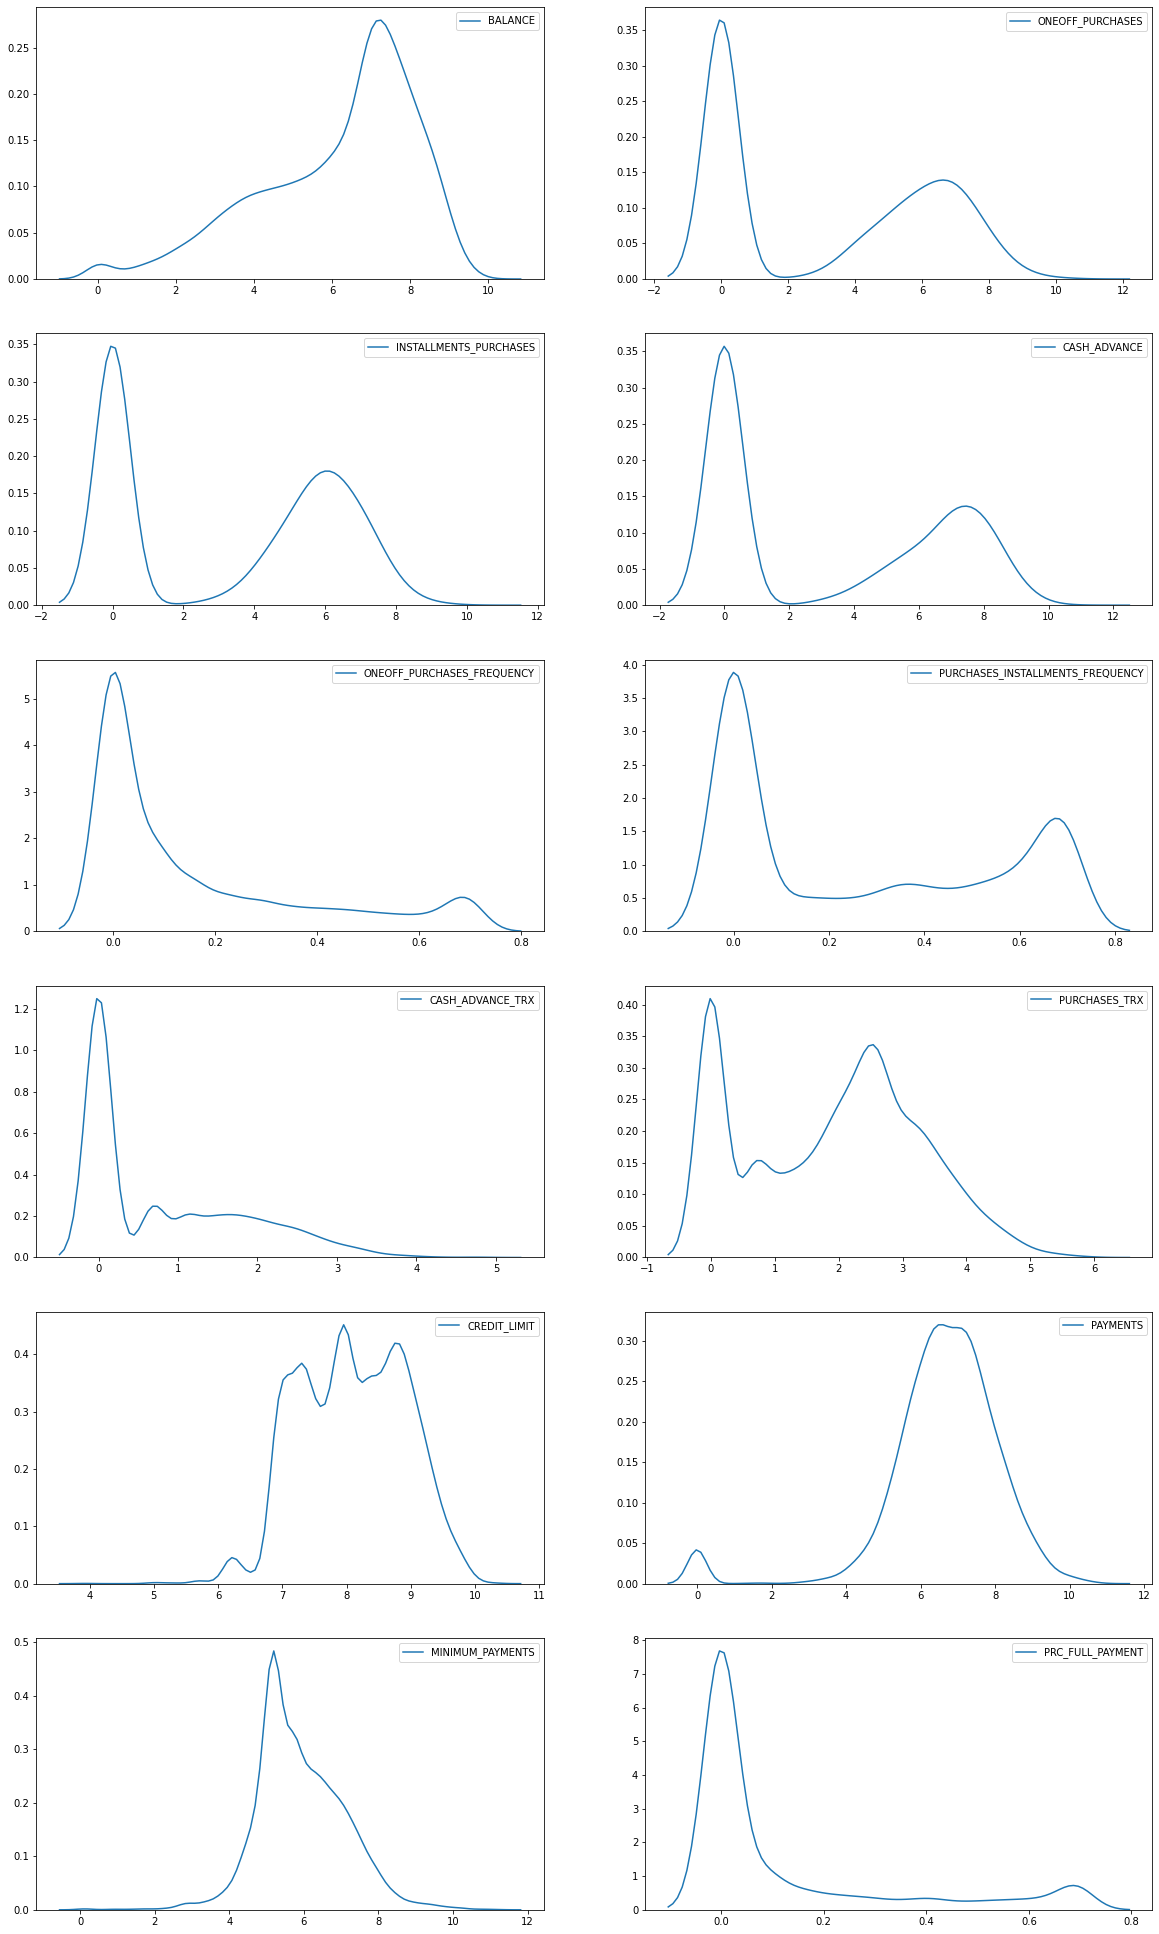

In [12]:
plt.figure(figsize=(20,35))
for i,col in enumerate(cols):
    ax=plt.subplot(6,2,i+1)
    sns.kdeplot(data[col], ax=ax)
plt.show()

The distribution is much better than before

From our correlation before, we spotted that some features were highly correlated.
We will use PCA to deal with it.
PCA deals with dimensionality reduction by finding new axis or dimensions in the dataset that explains most the variance in the data
The best that explains the maximum variance is the first principal component. It goes on by choosing another one that is perpendicular to the first

In [13]:
#Applying PCA on our data
# We want components that can explain at least 95% of the variance
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
data_reduced = pca.fit_transform(data)

# Model training

We will be using KMeans clustering algorithm in our task.
It is an unsupervised algorithm that groups together similar data in the same cluster with a given k number of clusters. Data points in the same cluster should be more similar than with other data in other clusters

Choosing the best number of clusters can be tricky at times.This number will impact the effectiveness of the clustering
There are various ways of doing it, one way would be to visualize the data and get a certain number by intuition. This can work sometimes
But visualizing is not always enough. 
We can use distortion and inertia to get the optimum value of k.


Distortion is the average of the squared distances from the cluster centers of the respective clusters.Euclidean distance metric is used
Inertia is the sum of squared distances of samples to their closest cluster center.
We will try k in the range of 1 to 9

In [14]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [15]:
distortion =[]
inertia = []
for k in range(1,10):
    kmodel = KMeans(n_clusters=k).fit(data_reduced)
    distortion.append(sum(np.min(cdist(data_reduced, kmodel.cluster_centers_,'euclidean'), axis=1)) / data_reduced.shape[0])
    inertia.append(kmodel.inertia_)

In [16]:
#Another alternative
kmodels = [KMeans(n_clusters=k).fit(data_reduced) for k in range(1,10)]
distortion = [sum(np.min(
    cdist(data_reduced, kmodel.cluster_centers_,'euclidean'),
    axis=1)) / data_reduced.shape[0] for kmodel in kmodels]
inertia = [kmodel.inertia_ for kmodel in kmodels]

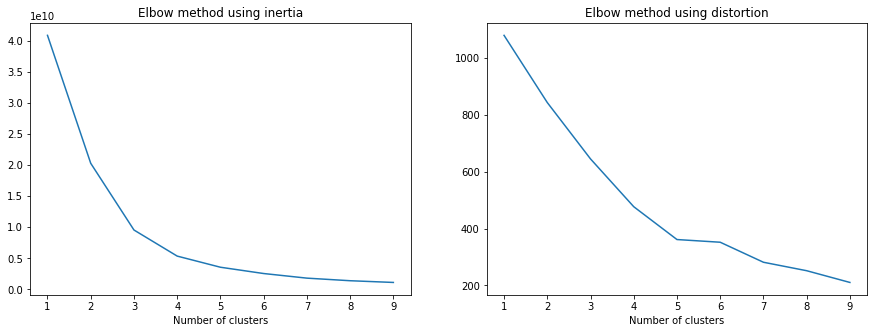

In [17]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(range(1,10),inertia)
axs[0].set_title('Elbow method using inertia')
axs[0].set_xlabel('Number of clusters')
axs[1].plot(range(1,10),distortion)
axs[1].set_title('Elbow method using distortion')
axs[1].set_xlabel('Number of clusters')
plt.show()

From the plots, it seems 3, 4 and 5 performs better.Let's use silhouette score to evaluate them

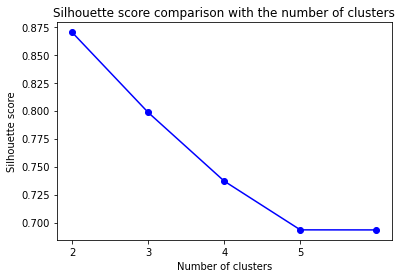

In [18]:
from sklearn.metrics import silhouette_score

scores = [silhouette_score(data_reduced,kmodel.labels_) for kmodel in kmodels[1:6]]

plt.plot(range(2,7), scores,'bo-')
plt.xticks([2,3,4,5])
plt.title('Silhouette score comparison with the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

2 seems to have a higher silhouette score. So we will use 2 clusters

In [19]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_reduced)

KMeans(n_clusters=2)

Add the clusters to our dataset

In [20]:
data['cluster'] = kmeans.labels_

For us to be able to visualize the results in the original scale, 
let's revert the logarithmic operation we performed earlier

In [21]:
for col in cols:
    data[col] = np.exp(data[col])

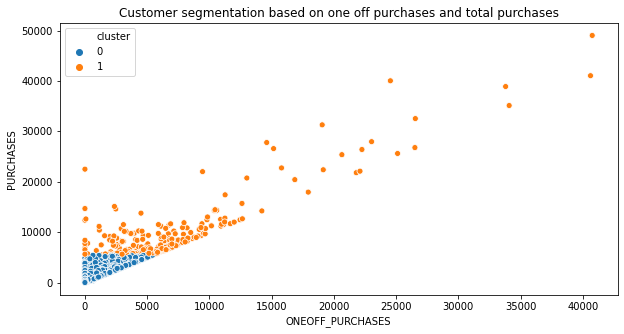

In [22]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data,x='ONEOFF_PURCHASES',y='PURCHASES',hue='cluster')
plt.title('Customer segmentation based on one off purchases and total purchases')
plt.show()

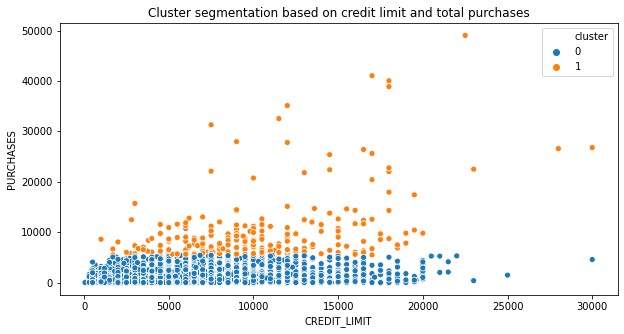

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.title('Cluster segmentation based on credit limit and total purchases')
plt.show()

When you look at the segmentation, our model grouped together customers who do not use credit card often in one group and those who use it frequently in another

Let's have a look at what 3 clusters would look like

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_reduced)
data['cluster']=kmeans.labels_

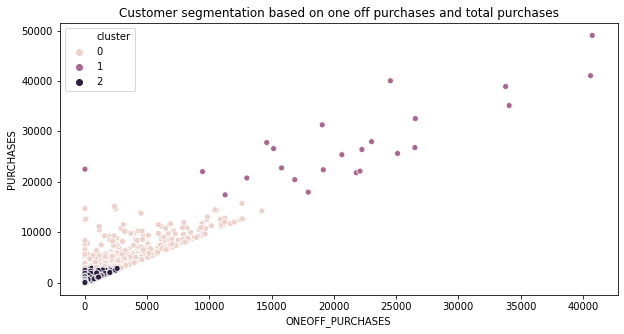

In [25]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data,x='ONEOFF_PURCHASES',y='PURCHASES',hue='cluster')
plt.title('Customer segmentation based on one off purchases and total purchases')
plt.show()

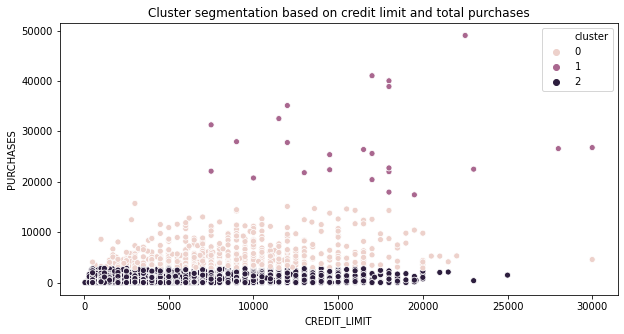

In [26]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.title('Cluster segmentation based on credit limit and total purchases')
plt.show()

I would choose 3 clusters as they separate those who have very high usage of credit card from others